In [1]:
import numpy as np
import torch
import torch.nn as nn
from IPython.display import display, HTML
from transformers import DistilBertModel, DistilBertTokenizer, logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm as tqdm_notebook
import seaborn as sns
import pandas as pd
import numpy as np
import collections
from collections import Counter
import glob
import pickle
import random
from scipy.special import softmax
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
import sys
from sklearn.preprocessing import LabelBinarizer

In [2]:
logging.set_verbosity_error()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')

In [3]:
# Own Functions
from build_features import similarity_matrix as vector_values
from predict_model import load_CUB_Bert, load_simBERT, loadBERT
from predict_model import SpanPredictor as classify

In [4]:
output = 549

In [5]:
model = load_CUB_Bert("../models/", 'saved_weights_PlantSpecies_549.pt', outputsize=output)

Local Success


In [33]:
TRAIN = pickle.load(open('../data/processed/RDF_TEXT_TRAIN_V2_SET_554.pkl', 'rb'))
TEST = pickle.load(open('../data/processed/RDF_TEXT_TEST_V2_SET_554.pkl', 'rb'))

In [34]:
lb = LabelBinarizer()
keys = np.array([key for key in TRAIN.keys()])
keys_encoded = lb.fit_transform(keys)

In [35]:
def WhichPlant(span, model):
    
    with torch.no_grad():
        # Tokenize input
        inputs = tokenizer(span, return_tensors="pt", truncation=True )
        # Predict class
        outputs = model(**inputs)
        # Get prediction values
        exps = torch.exp(outputs)
        # Get class
        probs = exps.detach().numpy()
        
        #return np.squeeze(probs)
        
        # TESTING
        outputs = outputs.detach().numpy()
    return np.squeeze(outputs)

In [36]:
#WhichPlant('this is a test ', model=model)

In [75]:
plant_idx = 80
species = list(TEST.keys())
plant = species[plant_idx]
print('NAME:', plant)

NAME: moringa stenopetala


In [76]:
#plant = list(data.keys())[1]
print(plant)

h, w = (len(TEST[plant]), output)

logstack = np.empty((h, w), float)
probstack = np.empty((h, w), float)
logstack_raw = np.empty((h, w), float)

for idx, text in enumerate(tqdm_notebook(TEST[plant][0:])):
    

    probs = WhichPlant(text, model=model)
    if idx == 0:
        logstack[idx] = probs
        probstack[idx] = softmax(probs)
        logstack_raw[idx] = probs
    else:
        logstack[idx] = logstack[idx-1] + probs
        probstack[idx] = softmax(logstack[idx-1] + probs)
        logstack_raw[idx] = probs

moringa stenopetala


  0%|          | 0/39 [00:00<?, ?it/s]

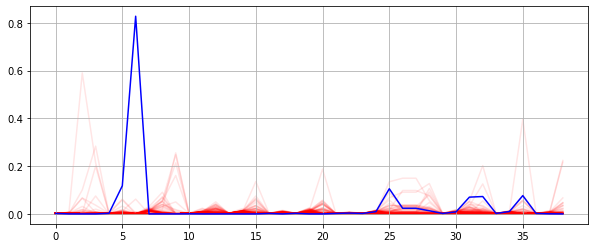

In [77]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(0, output):
    if i == np.where(lb.classes_ == plant)[0][0]:
        ax.plot(np.exp(logstack_raw[:, i]), color='blue', alpha=1, markersize=5, zorder=2)
    else:
        
        ax.plot(np.exp(logstack_raw[:, i]), color='red', alpha=0.1, zorder=1)
plt.grid()

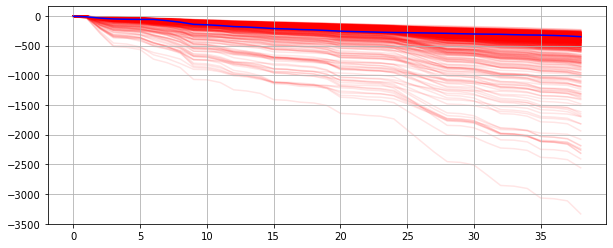

In [78]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(0, output):
    if i == np.where(lb.classes_ == plant)[0][0]:
        ax.plot(logstack[:, i], color='blue', alpha=1, markersize=5, zorder=2)
    else:
        
        ax.plot(logstack[:, i], color='red', alpha=0.1, zorder=1)
plt.grid()

In [79]:
correct = []
incorrect = []


for plant in tqdm_notebook(species[0:]):
    
    h, w = (len(TEST[plant]), output)
    
    if h < 0:
        continue
    
    logstack = np.zeros((h, w), float)
    probstack = np.zeros((h, w), float)
    # Plant index
    plantID = np.where(lb.classes_ == plant)[0][0]
    try:
        for idx, text in enumerate((TEST[plant][0:])):

            probs = WhichPlant(text, model=model)
            if idx == 0:
                logstack[idx] = probs
                probstack[idx] = softmax(probs)

            else:
                logstack[idx] = logstack[idx-1] + probs
                probstack[idx] = softmax(logstack[idx-1] + probs)
            
        correct.append(logstack[-1][plantID])
        incorrect += list(np.delete(logstack[-1], plantID).mean())
    except:
        continue
    

  0%|          | 0/227 [00:00<?, ?it/s]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [82]:
'Capparis decidua'

'Capparis decidua'

In [70]:
logstack[-1][plantID]

-2220.4449184015393

In [88]:
correct = np.array(correct)
incorrect = np.array(incorrect)

In [89]:
np.save('../data/plotting/model_pred_correct', correct)
np.save('../data/plotting/model_pred_incorrect', incorrect)

In [70]:
d = {'Yes': correct, 'No': incorrect}
df = pd.DataFrame(dict([ (k, pd.Series(v)) for k, v in d.items() ]))
df_m = df.melt()

In [71]:
stats.mannwhitneyu(correct, incorrect, alternative='greater')

MannwhitneyuResult(statistic=14363649.0, pvalue=0.008610153265594446)

In [ ]:
stats.wilcoxon(correct, incorrect, alternative='greater')

In [72]:
stats.ttest_ind(correct, incorrect, alternative='greater', equal_var=True)

Ttest_indResult(statistic=-0.6572026223352551, pvalue=0.7444740511434962)

<AxesSubplot:xlabel='variable', ylabel='value'>

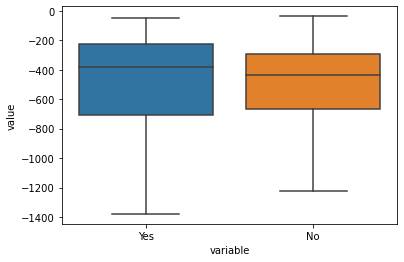

In [73]:
sns.boxplot(x="variable", y="value", data=df_m, showfliers=False)

<AxesSubplot:xlabel='value', ylabel='variable'>

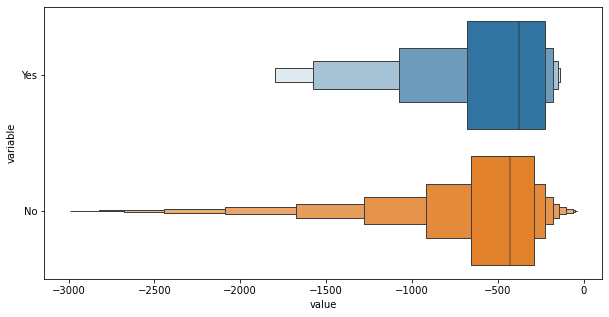

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxenplot(x="value", y="variable", data=df_m[df_m['value'] > -3000],
             scale='exponential', showfliers=False)

In [ ]:
df_m[df_m['value'] > -3000]